In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [96]:
def extract_date(df, date_col):
    df.copy(deep=True)
    df['hour'] = df[date_col].dt.hour
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['week'] = df[date_col].dt.week
    df['day'] = df[date_col].dt.dayofyear
    return df 

### Load Hourly MEFs from Simple Dispatch Model

In [405]:
df_2017 = pd.read_csv('simple_dispatch_mef/final_mefs_PJM_2017.csv', parse_dates = [1])
df_2016 = pd.read_csv('simple_dispatch_mef/final_mefs_PJM_2016.csv', parse_dates = [1])

In [406]:
#df_2017 = df_2017[['datetime', 'demand','co2_marg']]

# Drop outliers
df_2017 = df_2017[df_2017.co2_marg < 2000]

df_2017 = extract_date(df_2017, 'datetime')

In [407]:
#df_2017 = df_2017[['datetime', 'demand','co2_marg']]

# Drop outliers
df_2016 = df_2016[df_2016.co2_marg < 2000]

df_2016 = extract_date(df_2016, 'datetime')

In [120]:
df_2017_head = df_2017.head(100)

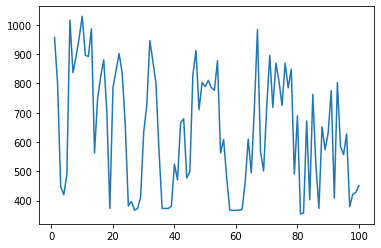

In [121]:
plt.plot(df_2017_head['co2_marg'])

### Quickly Check that Data Makes Sense Against Regression MEFs

##### Monthly MEFs

In [122]:
monthly_mefs = df_2017.groupby( ['month'] ).mean().reset_index()
regression_monthly = pd.read_csv('regression_mef/monthly_mef.csv')

# Look at 2017 data only 
regression_monthly_2017 = regression_monthly.loc[regression_monthly['year'] == 2017]
regression_monthly_2017 = regression_monthly_2017[['month', 'factor']]

regression_monthly_2017 = regression_monthly_2017.merge(monthly_mefs, how='inner', on=['month'])

regression_monthly_2017=regression_monthly_2017.rename(columns = {'factor':'regression', 'co2_marg': 'simple_dispatch'})

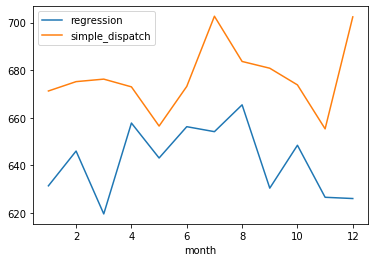

In [124]:
regression_monthly_2017.plot(x="month", y=["regression", "simple_dispatch"], kind="line")

##### Hourly MEFs

In [125]:
hourly_mefs = df_2017.groupby( ['hour'] ).mean().reset_index()
regression_hourly = pd.read_csv('regression_mef/2017_hourly_mef.csv')

# Look at 2017 data only 
regression_hourly = regression_hourly[['hour', 'factor']]

regression_hourly = regression_hourly.merge(hourly_mefs, how='inner', on=['hour'])

regression_hourly = regression_hourly.rename(columns = {'factor':'regression', 'co2_marg': 'simple_dispatch'})


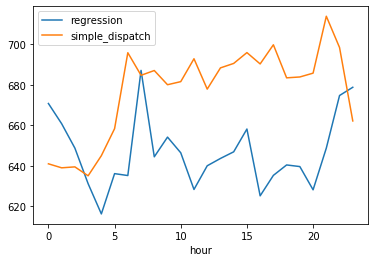

In [126]:
regression_hourly.plot(x="hour", y=["regression", "simple_dispatch"], kind="line")

### Process Data to Predict MEF Directly with Neural Net

##### Combine Import / Export, Weather, and Demand Data Together

In [408]:
weather_train = pd.concat(map(pd.read_csv, ['processed_data/raw_weather_train.csv', 'processed_data/raw_weather_test.csv']))

#weather_train = pd.read_csv('processed_data/raw_weather_train.csv')
load_data = pd.read_csv('processed_data/load_processed.csv')

features = load_data.merge(weather_train, on = ['year', 'month', 'day'])

In [409]:
co2_marg = pd.concat([df_2017, df_2016], ignore_index=True)
demand = co2_marg[['demand', 'year', 'month', 'day', 'hour']]

In [412]:
# Pivot so this is by hour
demand = demand.pivot_table(index = ['year','month', 'day'], columns="hour", values=['demand'])
demand.columns = demand.columns.map('{0[0]}|{0[1]}'.format)

features = features.merge(demand, on = ['year', 'month', 'day'])

# Remove columns that start with PJM (because that represents PJM demand data, which is currently duplicated)
features = features.loc[:,~features.columns.str.startswith('PJM')]

In [413]:
features

,year,month,day,MISO|0,MISO|1,MISO|2,MISO|3,MISO|4,MISO|5,MISO|6,...,demand|14,demand|15,demand|16,demand|17,demand|18,demand|19,demand|20,demand|21,demand|22,demand|23
0,2016,1,2,79963.0,80241.0,79140.0,77943.0,76022.0,73012.0,69062.0,...,39019.0,38267.0,38938.0,43153.0,46001.0,46455.0,46224.0,45164.0,43312.0,41713.0
1,2016,1,3,79271.0,79856.0,78950.0,77708.0,75630.0,72953.0,70250.0,...,42436.0,41869.0,42896.0,47459.0,51643.0,52875.0,52036.0,49599.0,46824.0,44493.0
2,2016,1,4,80602.0,81878.0,81112.0,79502.0,77122.0,73994.0,71565.0,...,57441.0,58106.0,61660.0,65888.0,70072.0,70584.0,69570.0,70203.0,66449.0,61314.0
3,2016,1,5,89111.0,90367.0,89456.0,87537.0,84308.0,80208.0,77012.0,...,63999.0,63530.0,65739.0,69461.0,71245.0,70615.0,70264.0,67461.0,63945.0,62179.0
4,2016,1,6,88570.0,89628.0,88771.0,86677.0,83099.0,79136.0,75425.0,...,58391.0,58608.0,58827.0,62651.0,65655.0,64713.0,63866.0,61049.0,57389.0,53967.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,2017,12,360,76328.0,78053.0,78579.0,77954.0,76723.0,74039.0,72950.0,...,61116.0,61459.0,62565.0,66450.0,69351.0,68464.0,66808.0,66383.0,64279.0,61696.0
714,2017,12,361,88006.0,88980.0,88482.0,86610.0,84301.0,80712.0,78086.0,...,73182.0,72990.0,75559.0,80299.0,80659.0,78785.0,79746.0,78676.0,75367.0,72790.0
715,2017,12,362,91319.0,92342.0,91681.0,89900.0,87696.0,84045.0,83289.0,...,77121.0,78965.0,80887.0,86251.0,88365.0,87670.0,86710.0,83465.0,79237.0,74964.0
716,2017,12,363,91635.0,92192.0,91395.0,89755.0,86981.0,84072.0,82384.0,...,72835.0,73156.0,74123.0,79580.0,80261.0,79822.0,79306.0,77082.0,73904.0,71031.0


In [414]:
target = co2_marg[['co2_marg', 'year', 'month', 'day', 'hour']]

# Pivot so this is by hour
target = target.pivot_table(index = ['year','month', 'day'], columns="hour", values=['co2_marg'])
target.columns = target.columns.map('{0[0]}|{0[1]}'.format)

In [418]:
features = features.set_index(['year', 'month', 'day'])

target = target.reset_index()
target = target.set_index(['year', 'month', 'day'])

target = target.dropna()

In [419]:
# Drop extra rows in target 
indx = target.index.difference(features.index)
target = target.drop(indx)

# Drop extra rows in features 
indx = features.index.difference(target.index)
features = features.drop(indx)

### Train / Test Split

In [422]:
def split(df):
    # 80-20 split 
    df = df.copy()
    
    train_pct_index = int(0.8 * len(df))
    X_train, X_test = df[:train_pct_index], df[train_pct_index:]

    return X_train, X_test

In [423]:
X_train, X_test = split(features)
Y_train, Y_test = split(target)

In [424]:
Y_test

co2_marg|0   co2_marg|1  co2_marg|2   co2_marg|3  \
year month day                                                      
2017 8     220   914.881213   834.239155  641.318499   419.839043   
           221   863.244652   959.502031  861.352683   379.332275   
           222   795.136576   902.759054  893.779154   379.332275   
           223   642.013451   857.215036  964.398108   983.639478   
           224   844.739172   868.854424  950.377066   895.897612   
...                     ...          ...         ...          ...   
     12    360   464.509871   703.642962  818.696454   719.260927   
           361   570.875522   523.110310  432.329759   578.331910   
           362  1029.562694  1177.997847  943.837985  1486.242647   
           363   881.933380   983.508364  935.398489   945.619357   
           364   903.198988   670.636017  601.259600   724.784444   

                 co2_marg|4   co2_marg|5  co2_marg|6  co2_marg|7  co2_marg|8  \
year month day                                                                 
2017 8     220   872.396214   897.049717  792.888080  474.981078  580.264590   
           221   932.028665   844.844645  606.086681  531.471931  527.782739   
           222   943.236324   843.598732  589.804368  541.297821  560.141768   
           223   861.415533   663.441279  556.721262  532.471617  601.921050   
           224   901.348487   892.006634  965.407384  862.319842  683.656621   
...                     ...          ...         ...         ...         ...   
     12    360   590.585144   477.259188  548.777837  553.912925  534.972288   
           361   504.796423   727.072468  705.476198  944.231214  914.907031   
           362  1486.242647   833.942305  700.660146  683.883782  588.150186   
           363   949.723572  1014.323180  783.871573  673.112931  350.346207   
           364   797.238989   797.238989  607.593025  796.659562  514.316219   

                co2_marg|9  ...  co2_marg|14  co2_marg|15  co2_marg|16  \
year month day              ...                                          
2017 8     220  575.084167  ...   753.797448   783.406267   953.904924   
           221  551.929173  ...   911.135323   808.486510   474.134920   
           222  688.900065  ...   802.340442   574.587261   931.717481   
           223  672.890103  ...   856.510782   764.524241   821.031017   
           224  535.366529  ...   645.384274   615.754487   685.320920   
...                    ...  ...          ...          ...          ...   
     12    360  759.636807  ...   379.156808   796.712309   864.404551   
           361  826.161085  ...  1283.459356  1125.034910   753.865187   
           362  553.351427  ...   454.282163   591.278861   781.067139   
           363  350.346207  ...  1486.242647  1333.602672   722.578737   
           364  838.216306  ...   672.353505   997.405882   894.288827   

                co2_marg|17  co2_marg|18  co2_marg|19  co2_marg|20  \
year month day                                                       
2017 8     220   878.564703   951.275208   767.165138   456.569025   
           221   350.558584   756.163984   758.768252  1004.393574   
           222   533.262843   702.760083   918.884827   946.355617   
           223  1078.430951   921.964022   913.187142   751.826854   
           224   683.387152   797.238989   754.556137   528.072317   
...                     ...          ...          ...          ...   
     12    360   640.734850   881.238236  1009.884934   863.714733   
           361   712.844197   917.583543   800.857121   855.652518   
           362   590.605195   653.207019   550.848139   616.591694   
           363   728.774001   598.121543   612.882226   750.756810   
           364   929.106423   751.590855   824.310421   738.031294   

                co2_marg|21  co2_marg|22  co2_marg|23  
year month day                                         
2017 8     220   680.080253   536.505504   683.784116  
           221   753.509539   603.98

### Circular Encoding

In [372]:
# Circular encoding of day of year and month 
def sin_cos_correction(df):
    df = df.reset_index()
    
    df['day_sin'] = np.sin((df['day']-1)*(2.*np.pi/365))
    df['day_cos'] = np.cos((df['day']-1)*(2.*np.pi/365))
    df['month_sin'] = np.sin((df['month']-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((df['month']-1)*(2.*np.pi/12))
    
    df = df.drop(['month', 'day'], axis=1)
    df = df.set_index(['year', 'month_sin', 'month_cos', 'day_sin', 'day_cos'])
    return df

In [373]:
X_train = sin_cos_correction(X_train)
X_test = sin_cos_correction(X_test)

In [374]:
Y_train = sin_cos_correction(Y_train)
Y_test = sin_cos_correction(Y_test)

In [375]:
Y_test

co2_marg|0.0  co2_marg|1.0  \
year   month_sin month_cos     day_sin   day_cos                                
2017.0 -1.0      -1.836970e-16 -0.956235 0.292600    605.416031    717.982612   
                               -0.951057 0.309017    798.604911    454.171740   
                               -0.945596 0.325342    488.984328    386.358590   
                               -0.939856 0.341571    585.769162    648.740278   
                               -0.933837 0.357698    470.431768    380.063846   
...                                                         ...           ...   
       -0.5       8.660254e-01 -0.103102 0.994671    464.509871    703.642962   
                               -0.085965 0.996298    570.875522    523.110310   
                               -0.068802 0.997630   1029.562694   1177.997847   
                               -0.051620 0.998667    881.933380    983.508364   
                               -0.034422 0.999407    903.198988    670.636017   

                                                   co2_marg|2.0  co2_marg|3.0  \
year   month_sin month_cos     day_sin   day_cos                                
2017.0 -1.0      -1.836970e-16 -0.956235 0.292600    366.875187    638.328368   
                               -0.951057 0.309017    378.372888    439.694834   
                               -0.945596 0.325342    469.921102    485.824862   
                               -0.939856 0.341571    842.641111    563.587376   
                               -0.933837 0.357698    530.469761    461.074144   
...                                                         ...           ...   
       -0.5       8.660254e-01 -0.103102 0.994671    818.696454    719.260927   
                               -0.085965 0.996298    432.329759    578.331910   
                               -0.068802 0.997630    943.837985   1486.242647   
                               -0.051620 0.998667    935.398489    945.619357   
                               -0.034422 0.999407    601.259600    724.784444   

                                                   co2_marg|4.0  co2_marg|5.0  \
year   month_sin month_cos     day_sin   day_cos                                
2017.0 -1.0      -1.836970e-16 -0.956235 0.292600    541.570301    661.235378   
                               -0.951057 0.309017    621.720331    622.886989   
                               -0.945596 0.325342    473.060646    607.355435   
                               -0.939856 0.341571    684.232619    694.544374   
                               -0.933837 0.357698    514.736134    563.452442   
...                                                         ...           ...   
       -0.5       8.660254e-01 -0.103102 0.994671    590.585144    477.259188   
                               -0.085965 0.996298    504.796423    727.072468   
                               -0.068802 0.997630   1486.242647    833.942305   
                               -0.051620 0.998667    949.723572   1014.323180   
                               -0.034422 0.999407    797.238989    797.238989   

                                                   co2_marg|6.0  co2_marg|7.0  \
year   month_sin month_cos     day_sin   day_cos                                
2017.0 -1.0      -1.836970e-16 -0.956235 0.292600    879.098088    818.696454   
                               -0.951057 0.309017    899.234164    877.573269   
                               -0.945596 0.325342    610.413805    402.471086   
                               -0.939856 0.341571    466.277706    487.019641   
                               -0.933837 0.357698    882.479900    847.939608   
...                                                         ...           ...   
       -0.5       8.660254e-01 -0.103102 0.994671    548.777837    553.912925   
                               -0.085965 0.996298    705.476198    944.231214   
                               -0.068802 0.997630    700.660146    683.883782  

### Standardize

In [240]:
# Standardize features 
scaler = StandardScaler()
scaler.fit(X_train.values) # fit on training set 

scaled_X_train = scaler.transform(X_train.values)
scaled_X_test = scaler.transform(X_test.values)

# Convert back to df after scaling 
X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaled_X_test, index=X_test.index, columns=X_test.columns)

In [344]:
X_train.to_csv("predict_simple_dispatch/X_Train.csv")
X_test.to_csv("predict_simple_dispatch/X_Test.csv")

In [345]:
Y_train.to_csv("predict_simple_dispatch/Y_train.csv")
Y_test.to_csv("predict_simple_dispatch/Y_test.csv")

## Predictions with Simple Dispatch Model
Take the previous 4 week's MEF to create a function and then given demand, create the plot 

Look at how max demand changes week to week 

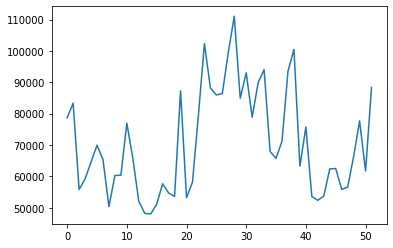

In [654]:
# The largest demand value fluctuates which means that there are some weeks where there's no data 
weekly_df_2017 = df_2017.groupby( ['week'] ).max().reset_index()
weekly_df_2017.demand.plot()

In [655]:
def demand_vs_mef_df(week, simple_dispatch_df):
    prev_week = predict_week - 1
    prev_data = simple_dispatch_df.loc[simple_dispatch_df['week'] == prev_week]

    sim_sorted = prev_data[['demand', 'datetime', 'coal_mix', 'co2_tot', 'so2_tot', 'nox_tot', 'gen_cost_marg']].sort_values(by='demand').copy()
    
    p = 10 
    sim_sorted['dlow'] = list(np.repeat(0, p/2.)) + list(sim_sorted.demand.iloc[0:-p]) + list(np.repeat(0, p/2.))
    sim_sorted['dhigh'] = list(np.repeat(0, p/2.)) + list(sim_sorted.demand.iloc[p:]) + list(np.repeat(0, p/2.))
    sim_sorted['dd'] = sim_sorted.dhigh - sim_sorted.dlow

    e = 'co2'
    sim_sorted[e+'_tot_rolling'] = sim_sorted[e+'_tot'].rolling(window=p*2, min_periods=p*2, center=True).mean()

    sim_sorted[e + 'low'] = list(np.repeat(0, p/2.)) + list(sim_sorted[e + '_tot_rolling'].iloc[0:-p]) + list(np.repeat(0, p/2.))
    sim_sorted[e + 'high'] = list(np.repeat(0, p/2.)) + list(sim_sorted[e + '_tot_rolling'].iloc[p:]) + list(np.repeat(0, p/2.))
    sim_sorted['d'+e] = sim_sorted[e + 'high'] - sim_sorted[e + 'low']
    sim_sorted[e+'slope_0'] = np.divide(sim_sorted['d'+e], sim_sorted.dd)
    sim_sorted[e+'_slope'] = sim_sorted[e+'slope_0'].rolling(window=p, min_periods=p, center=True).mean()
    sim_sorted['gen_cost_marg_rolling'] = sim_sorted['gen_cost_marg'].rolling(window=p*2, min_periods=p*2, center=True).mean()
    
    sim_sorted['dlow'] = list(np.repeat(0, p/2.)) + list(sim_sorted.demand.iloc[0:-p]) + list(np.repeat(0, p/2.))
    sim_sorted['dhigh'] = list(np.repeat(0, p/2.)) + list(sim_sorted.demand.iloc[p:]) + list(np.repeat(0, p/2.))
    sim_sorted['dd'] = sim_sorted.dhigh - sim_sorted.dlow

    df = pd.DataFrame()
    df['x'] = sim_sorted[sim_sorted['co2_slope'].notna()]['demand']/1e3
    df['y'] = sim_sorted[sim_sorted['co2_slope'].notna()]['co2_slope']
    df['week'] = week
    
    return df


In [656]:
def get_mef(demand, df):
    return np.interp(demand//1e3, df.x, df.y)

Generate Predictions Each Week 

In [660]:
# Load demand data 
fossil_gen = pd.read_csv('Predictions/fossil_gen.csv')
fossil_gen = fossil_gen[['year', 'month', 'day', 'hour', 'fossil gen']]

In [661]:
# Add week and datetime columns 

fossil_gen['datetime'] = pd.to_datetime(fossil_gen['year'] * 1000 + fossil_gen['day'], format='%Y%j')

fossil_gen['week'] = fossil_gen['datetime'].dt.week

In [663]:
predicted_mef_df = pd.DataFrame()
for week in range(32, 53):
    df = demand_vs_mef_df(week, df_2017)
    demand_week = fossil_gen.loc[fossil_gen['week'] == week]
    demand_week['predicted_mef'] = get_mef(demand_week['fossil gen'], df)
    
    predicted_mef_df = predicted_mef_df.append(demand_week)


/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [664]:
predicted_mef_df = predicted_mef_df.rename(columns = {'predicted_mef': 'predicted_with_model'})

### Compare Simple Dispatch and Direct Predictions 

In [666]:
# Load actual MEFs from simple dispatch and direct MEF predictions 

simple_dispatch_mef = pd.read_csv('Predictions/actual_mef_test.csv', usecols = ['year','month', 'day', 'hour', 'value'])
predicted_direct_mef = pd.read_csv('Predictions/direct_mef_pred.csv', usecols = ['year','month', 'day', 'hour', 'value'])

simple_dispatch_mef = simple_dispatch_mef.rename(columns = {'value': 'actual'})
predicted_direct_mef = predicted_direct_mef.rename(columns = {'value': 'predicted_direct'})


In [691]:
# Merge this with previous predictions
mef = simple_dispatch_mef.merge(predicted_direct_mef, how='inner', on=['year', 'month', 'day', 'hour'])
mef = mef.merge(predicted_mef_df, how='inner', on=['year', 'month', 'day', 'hour'])

### Compare the two prediction methods with actual

In [693]:
# First 150 values 
mef = mef.drop(['year', 'month', 'day', 'fossil gen', 'week'], axis = 1)

In [694]:
mef = mef.set_index(['datetime', 'hour'])

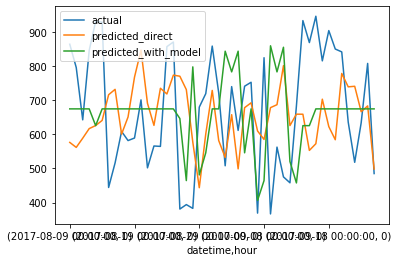

In [699]:
# Look at the first 2 days
mef_head = mef.head(48)
mef_head.plot()

In [701]:
# Hour of day 
mef = mef.reset_index()
mef_hour = mef.groupby( ['hour'] ).mean().reset_index()

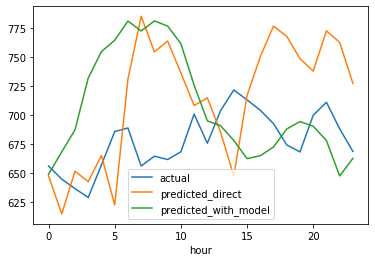

In [704]:
mef_hour = mef_hour.set_index('hour')
mef_hour.plot()

In [710]:
# Weekly 
mef['week'] = mef.datetime.dt.week
mef_week = mef.groupby( ['week'] ).mean().reset_index()

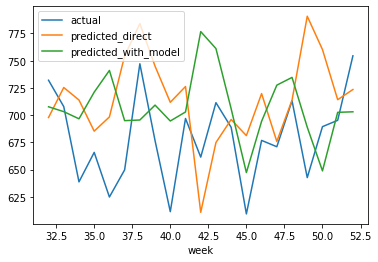

In [714]:
mef_week = mef_week[['week', 'actual', 'predicted_direct', 'predicted_with_model']]

mef_week = mef_week.set_index('week')
mef_week.plot()
